In [6]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

print(f"TensorFlow version: {tf.__version__}")
print(f"TF Datasets version: {tfds.__version__}")

TensorFlow version: 2.19.0
TF Datasets version: 4.9.9


Here I am asking Trensflow to find the files and download it

In [7]:
(ds_train, ds_valid), info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)

print(f"Classes: {info.features['label'].names}")
print(f"Pics for trainings: {tf.data.experimental.cardinality(ds_train)}")
print(f"Pics for validations: {tf.data.experimental.cardinality(ds_valid)}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.UJXFG0_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Classes: ['cat', 'dog']
Pics for trainings: 18610
Pics for validations: 4652


Now I need to preprocess the data and resize the images

In [8]:
IMAGE_SIZE = (160, 160)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
])

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [9]:
def format_image(image, label):
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32)
    return image, label

In [10]:
ds_train = ds_train.map(format_image, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(1000)
ds_train = ds_train.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=AUTOTUNE)
ds_train = ds_train.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(buffer_size=AUTOTUNE)
ds_valid = ds_valid.map(format_image, num_parallel_calls=AUTOTUNE)
ds_valid = ds_valid.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
ds_valid = ds_valid.batch(BATCH_SIZE)
ds_valid = ds_valid.cache()
ds_valid = ds_valid.prefetch(buffer_size=AUTOTUNE)

print("Converted data is ready!")

Converted data is ready!


In [11]:
IMG_SHAPE = IMAGE_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [14]:
EPOCHS = 5
history = model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_valid
)

Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 168s 256ms/step - accuracy: 0.7035 - loss: 0.5314 - val_accuracy: 0.9460 - val_loss: 0.1443
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 99s 170ms/step - accuracy: 0.9033 - loss: 0.2230 - val_accuracy: 0.9641 - val_loss: 0.0967
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 141s 168ms/step - accuracy: 0.9239 - loss: 0.1771 - val_accuracy: 0.9721 - val_loss: 0.0798
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 142s 168ms/step - accuracy: 0.9304 - loss: 0.1647 - val_accuracy: 0.9740 - val_loss: 0.0720
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 97s 167ms/step - accuracy: 0.9360 - loss: 0.1521 - val_accuracy: 0.9761 - val_loss: 0.0668


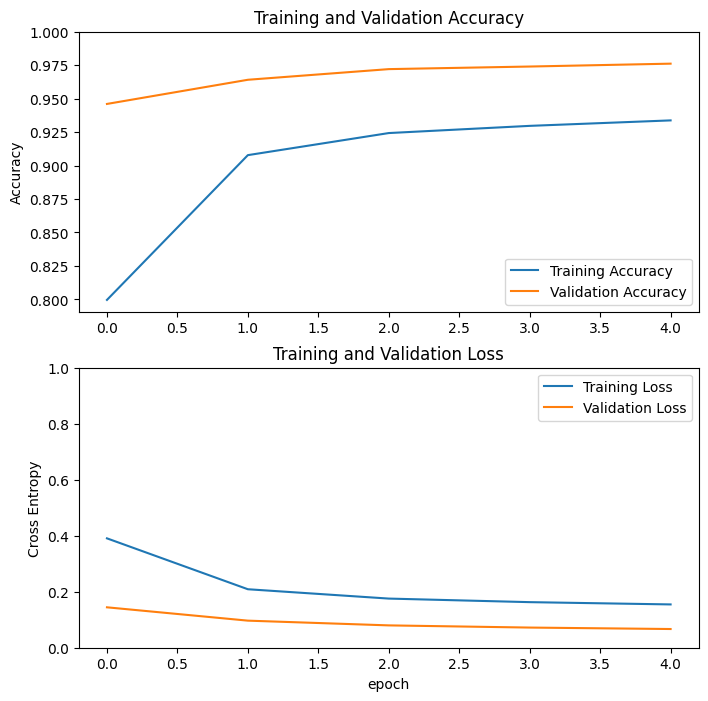

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [16]:
ADDITIONAL_EPOCHS = 15
TOTAL_EPOCHS = EPOCHS + ADDITIONAL_EPOCHS
print(f"Learning {ADDITIONAL_EPOCHS} epoches...")
history_fine = model.fit(
    ds_train,
    epochs=TOTAL_EPOCHS,
    initial_epoch=history.epoch[-1],
    validation_data=ds_valid
)

Learning 15 epoches...
Epoch 5/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 98s 168ms/step - accuracy: 0.9411 - loss: 0.1389 - val_accuracy: 0.9776 - val_loss: 0.0630
Epoch 6/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 97s 166ms/step - accuracy: 0.9415 - loss: 0.1393 - val_accuracy: 0.9787 - val_loss: 0.0605
Epoch 7/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 96s 165ms/step - accuracy: 0.9439 - loss: 0.1314 - val_accuracy: 0.9798 - val_loss: 0.0585
Epoch 8/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 143s 166ms/step - accuracy: 0.9410 - loss: 0.1384 - val_accuracy: 0.9800 - val_loss: 0.0574
Epoch 9/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 96s 165ms/step - accuracy: 0.9446 - loss: 0.1334 - val_accuracy: 0.9804 - val_loss: 0.0562
Epoch 10/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 99s 170ms/step - accuracy: 0.9458 - loss: 0.1292 - val_accuracy: 0.9811 - val_loss: 0.0553
Epoch 11/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 96s 165ms/step - accuracy: 0.9464 - loss: 0.1265 - val_accuracy: 0.9817 - val_loss: 0.0544
Epoch 12/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 96s 165ms/step -

In [17]:
model_filename = 'dogs_vs_cats_classifier.keras'
model.save(model_filename)
print(f"Моделът е временно запазен като: {model_filename}")

Моделът е временно запазен като: dogs_vs_cats_classifier.keras


In [18]:
from google.colab import files
files.download(model_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

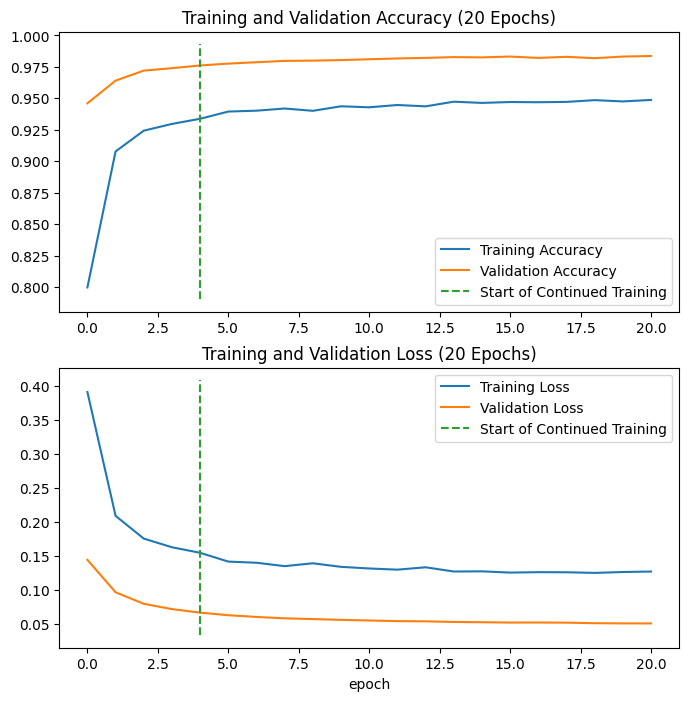

In [26]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([EPOCHS-1, EPOCHS-1], plt.ylim(), label='Start of Continued Training', linestyle='--')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (20 Epochs)')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([EPOCHS-1, EPOCHS-1], plt.ylim(), label='Start of Continued Training', linestyle='--')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (20 Epochs)')
plt.xlabel('epoch')
plt.show()

Please upload a picture of Dof or Cat:


Saving images.webp to images.webp
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


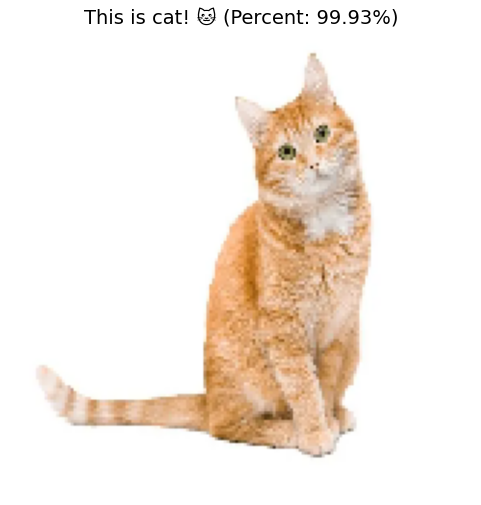

In [20]:
import numpy as np
import tensorflow as tf
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
IMAGE_SIZE = (160, 160)
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
active_model = model
print("Please upload a picture of Dof or Cat:")
uploaded = files.upload()
if not uploaded:
    print("\nThe file is not uploaded.")
else:
    filename = list(uploaded.keys())[0]
    img = tf.keras.utils.load_img(
        filename,
        target_size=IMAGE_SIZE
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_batch)
    prediction_logits = active_model.predict(img_preprocessed)
    score = tf.nn.sigmoid(prediction_logits[0][0]).numpy()
    if score < 0.5:
        result_text = f"This is cat! 🐱 (Percent: {100 * (1 - score):.2f}%)"
    else:
        result_text = f"This is dog! 🐶 (Percent: {100 * score:.2f}%)"
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(result_text, fontsize=14)
    plt.axis('off')
    plt.show()

In [21]:
!pip install gradio

In [22]:
import gradio as gr
import numpy as np
import tensorflow as tf
IMAGE_SIZE = (160, 160)
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
active_model = model
def classify_image(input_image):
    img_resized = tf.image.resize(input_image, IMAGE_SIZE)
    img_batch = np.expand_dims(img_resized, axis=0)
    img_preprocessed = preprocess_input(img_batch)
    prediction_logits = active_model.predict(img_preprocessed)
    score = tf.nn.sigmoid(prediction_logits[0][0]).numpy()
    results = {
        "Cat ": float(1 - score),
        "Dog ": float(score)
    }

    return results

print("The function 'classify_image' is ready.")

The function 'classify_image' is ready.


In [23]:
%%writefile app.py

import gradio as gr
import numpy as np
import tensorflow as tf

try:
    model = tf.keras.models.load_model('dogs_vs_cats_classifier.keras')
except Exception as e:
    print(f"Error to loading: {e}")
    raise e

IMAGE_SIZE = (160, 160)
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

def classify_image(input_image):
    if input_image is None:
        return {"Грешка": 1.0}
    img_resized = tf.image.resize(input_image, IMAGE_SIZE)
    img_batch = np.expand_dims(img_resized, axis=0)
    img_preprocessed = preprocess_input(img_batch)
    prediction_logits = model.predict(img_preprocessed)
    score = tf.nn.sigmoid(prediction_logits[0][0]).numpy()
    results = {
        "Cat 🐱": float(1 - score),
        "Dog 🐶": float(score)
    }
    return results
iface = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="numpy"),
    outputs=gr.Label(num_top_classes=2),
    title="Classifier for Dogs and Cats",
    description="Upload a picture and check what module thing is it - Dog or Cat. Project from a 2nd year Computer Science student."
)
iface.launch()

Writing app.py


In [24]:
%%writefile requirements.txt
gradio
tensorflow
numpy

Writing requirements.txt


In [25]:
!ls -1

app.py
dogs_vs_cats_classifier.keras
images.webp
requirements.txt
sample_data
